## ARIMA&&RNN&&LSTM
```
概述：ARIMA RNN LSTM三种算法都会根据预测时刻之前的输入量来预测当前的数据。从基础上的思想上观察，都和脉冲信号的衰减和叠加的原理相似，好比在NT的时间间隔内有N个脉冲信号，且每一个信号的衰减时间是NT，那么在NT时刻的信号量不仅仅需要计算NT时刻的脉冲信号，而且需要前面NT时间间隔内所有信号尚未衰减完的信号。ARIMA RNN LSTM三种算法不同之处在于算法不同。 
```

### ARIMA
```
差分整合移动平均回归模型，首先通过原始数据的d阶差分计算使时间序列数据呈线性平滑变化的趋势，以便于预测；然后再通过预测时刻数据的p阶自相关系数确定有p阶数据对当前预测有影响；载然后通过预测时刻数据的q阶的偏自相关系数的计算确定q阶数据误差对当前数据预测影响较大；最后通过函数ARIMA(p,d,q)即可预测出当前的数据。
```
预测效果：
```
ARIMA算法在时间序列预测只能预测较短时间内的趋势而不能观察整体趋势
```

### RNN网络
```
RNN可以处理序列数据的神经网络，在序列预测的过程中会将前一时刻的预测中转数据信息作为当前预测操作的部分源输入数据。如RNN结构图所示。层与层之间通过权值连接，然后通过激活函数的过滤即可得到用于预测结果的特征数据。
```
<img src="RNN.png" style='zoom:40%;float:left' >


在RNN结构图中，每一个箭头代表一次带有权重值的变换。O代表输出，y代表样本给出的确定值，L代表损失函数。
注意：图中的W U V是权值共享的；每一个输入值都只和它本身所在的路线建立权连接，不会和别的神经元建立连接。

PS：对于W U V矩阵所保存的信息和ARIMA中p d q所表示的含义有些许相似之处，即确定当前时刻之前的输入数据对本次预测结果有贡献大小。

U V W超参数求解和BP不同的是，W U两个参数求解过程需要追溯之前所有的输入数据，进而在反向传播计算梯度时，很容易出现梯度消失和梯度爆炸的情况，为了解决梯度消失的情况，一般选择使用relu激活函数，但是即使使用relu激活函数，在当前预测输入之前的输入数据过多时，也会存在梯度消失情况，即RNN网络只能预测 短期记忆问题。为了解决此问题而提出LSTM算法结构。


### LSTM
```
长短期记忆网络是RNN的变体，RNN网络由于梯度消失的原因只能有短期记忆，LSTM通过网络学习单元的门控结构将短期记忆和长期记忆结合起来，并在一定程度上解决了梯度消失的问题。

LSTM和RNN不同，新增了一个用于控制细胞状态，即控制遗忘和记住的内容。
```

遗忘门：选择遗忘的信息，即线性变换和过滤，计算出非特征信息矩阵

<img src="LSTM遗忘门.png" style='zoom:60%' >

记忆门：选择记忆信息，计算需要更新的门控状态值，然后通过更新门控状态值计算需要保留的信息。

<img src="LSTM记忆门.png" style='zoom:50%' >

更新门控状态值

<img src="LSTM门状态更新.png" style='zoom:50%' >

使用门控状态值计算输出值

<img src="LSTM数据预测.png" style='zoom:50%' >

### 序列数据预测总结
```
ARIMA 只用于时间序列的数据预测
RNN  可以用于时间序列数据预测和短记忆序列数据预测
LSTM 可以用于时间序列数据预测和长短序列数据预测

PS：对于RNN LSTM网络一般会用于NLP中自然语言语义分析。但是从RNN LSTM算法实现中可以看出，其算法会只能根据历史输入词汇预测当前词的语义，但是这种算法不能涵盖所有语法规则，例如：干啥呀 ? / ?! /~ ，一句话后面根的语气词不同，则表达的意思完全不同，如果只通过前面的词语是如法预测这句话的语义。目前已经有BERT模型可以解决相似的问题。
```

# 算法实现

## 1.基于Tensorflow的Mnist数据集RNN网络实现

### 1-1获取数据

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf 
import numpy as np
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data


sess = tf.Session()
mnist = input_data.read_data_sets('data', one_hot=True)
print (mnist.train.images.shape)

Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz
(55000, 784)


### 1-2设置参数

In [3]:
lr = 1e-3
input_size = 28      # 每行输入28个特征点
timestep_size = 28   # 持续输入28行
hidden_size = 128    # 隐含层的数量
layer_num = 2        # LSTM layer 的层数
class_num = 10       # 10分类问题

_X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, class_num])

batch_size = tf.placeholder(tf.int32, [])  
keep_prob = tf.placeholder(tf.float32, [])

定义网络结构

<img src="LSTM网络结构.png" style='zoom:80%'>

In [4]:
# 定义LSTM细胞结构

def lstm_cell():
    cell = rnn.LSTMCell(hidden_size, reuse=tf.get_variable_scope().reuse)     #初始化一层神经网络的细胞元
    return rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)               #设定神经元的drop率 防止过拟合

In [5]:
X = tf.reshape(_X, [-1, 28, 28])

mlstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(layer_num)], state_is_tuple = True)   #搭建神经网络

#用全零来初始化状态
init_state = mlstm_cell.zero_state(batch_size, dtype=tf.float32)

#得到每一层的输出结果
outputs = list()
state = init_state 
with tf.variable_scope('RNN'):
    for timestep in range(timestep_size):
        if timestep > 0:
            tf.get_variable_scope().reuse_variables()
        (cell_output, state) = mlstm_cell(X[:, timestep, :],state)
        outputs.append(cell_output)
h_state = outputs[-1]

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
#Softmax层参数 定义输出函数
W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1,shape=[class_num]), dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(h_state, W) + bias)


# 损失和评估函数
cross_entropy = -tf.reduce_mean(y * tf.log(y_pre))
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


sess.run(tf.global_variables_initializer())
for i in range(1000):
    _batch_size = 128
    batch = mnist.train.next_batch(_batch_size)
    if (i+1)%200 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={
            _X:batch[0], y: batch[1], keep_prob: 1.0, batch_size: _batch_size})
        # 已经迭代完成的 epoch 数: mnist.train.epochs_completed
        print ("Iter%d, step %d, training accuracy %g" % ( mnist.train.epochs_completed, (i+1), train_accuracy))
    sess.run(train_op, feed_dict={_X: batch[0], y: batch[1], keep_prob: 0.5, batch_size: _batch_size})

# 计算测试数据的准确率
print ("test accuracy %g"% sess.run(accuracy, feed_dict={
    _X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0, batch_size:mnist.test.images.shape[0]}))

Iter0, step 200, training accuracy 0.914062
Iter0, step 400, training accuracy 0.929688
Iter1, step 600, training accuracy 0.984375
Iter1, step 800, training accuracy 0.945312
Iter2, step 1000, training accuracy 0.953125
test accuracy 0.969


In [7]:
_batch_size = 5
X_batch, y_batch = mnist.test.next_batch(_batch_size)
print (X_batch.shape, y_batch.shape)
_outputs, _state = sess.run([outputs, state],feed_dict={
            _X: X_batch, y: y_batch, keep_prob: 1.0, batch_size: _batch_size})
print ('_outputs.shape =', np.asarray(_outputs).shape)

(5, 784) (5, 10)
_outputs.shape = (28, 5, 128)


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


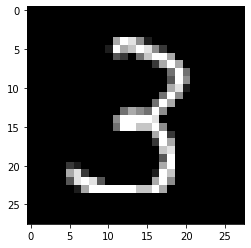

In [9]:
import matplotlib.pyplot as plt
print (mnist.train.labels[4])

X3 = mnist.train.images[4]
img3 = X3.reshape([28, 28])
plt.imshow(img3, cmap='gray')
plt.show()

In [10]:
X3.shape = [-1, 784]
y_batch = mnist.train.labels[0]
y_batch.shape = [-1, class_num]

X3_outputs = np.array(sess.run(outputs, feed_dict={
            _X: X3, y: y_batch, keep_prob: 1.0, batch_size: 1}))
print (X3_outputs.shape)
X3_outputs.shape = [28, hidden_size]
print (X3_outputs.shape)

(28, 1, 128)
(28, 128)


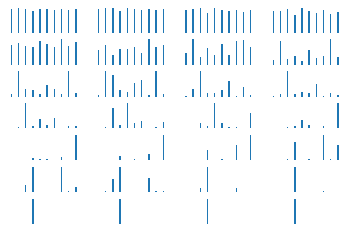

In [11]:
h_W = sess.run(W, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias = sess.run(bias, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias.shape = [-1, 10]

bar_index = range(class_num)
for i in range(X3_outputs.shape[0]):
    plt.subplot(7, 4, i+1)
    X3_h_shate = X3_outputs[i, :].reshape([-1, hidden_size])
    pro = sess.run(tf.nn.softmax(tf.matmul(X3_h_shate, h_W) + h_bias))
    plt.bar(bar_index, pro[0], width=0.2 , align='center')
    plt.axis('off')
plt.show()

## 2.基于Pytorch的Mnist数据集的RNN网络实现

```
minist数据集是28×28用于10 分类的数据。在当前例子中使用2层lstm网络层，中间隐层神经元个数为64，对于每一张图分成28次，每次28个特征数据进行输入。输入的每28个特征数据都会计算出64个特征结果，根据lstm的特征，一般选择最后一次输出数据用于特征判别。最后将64个特征数据得到10个得分值，然后对得分值进行交叉熵损失值计算，得到分类。
```

<img src="LSTM数据集.png" style='zoom:50%'>


In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [9]:
from torch  import nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(LSTM,self).__init__()
        self.lstm = nn.LSTM(
            input_size = in_channel,
            hidden_size = 64,
            num_layers = 2,
            dropout=0.5)     #默认两层LSTM
        self.out = nn.Linear(64,out_channel)
        self.h0 = torch.randn(2,28,64)
        self.c0 = torch.randn(2,28,64)
    
    def forward(self,x):
        output,(h_n,c_n)=self.lstm(x,(self.h0,self.c0))
        output_in_last_timestep=output[:,-1,:]
        x = F.relu(output_in_last_timestep)
        x = self.out(x)
        return x

LSTM参数解释：
1. https://blog.csdn.net/rogerfang/article/details/84500754
2. https://www.zhihu.com/question/41949741/answer/318771336

准确率评估标准

In [10]:
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1] 
    rights = pred.eq(labels.data.view_as(pred)).sum() 
    return rights, len(labels) 

网络模型训练

In [11]:
# 1. 加载数据
BATCH_SIZE = 64
training_dataset = torchvision.datasets.MNIST("./data/mnist", train=True,
                                              transform=torchvision.transforms.ToTensor(), download=True)
dataloader = Data.DataLoader(dataset=training_dataset,
                                      batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# showSample(dataloader)
test_data=torchvision.datasets.MNIST(root="./data/mnist",train=False,
                                    transform=torchvision.transforms.ToTensor(),download=False)
test_dataloader=Data.DataLoader(
    dataset=test_data,batch_size=1000,shuffle=False,num_workers=2) 

In [12]:
testdata_iter=iter(test_dataloader)
test_x,test_y=testdata_iter.next()
test_x=test_x.view(-1,28,28)
test_x.shape

torch.Size([1000, 28, 28])

In [13]:
in_channel = 28
out_channel = 10
net = LSTM(in_channel,out_channel)
optimizer=torch.optim.Adam(net.parameters(),lr=0.001)
loss_F=torch.nn.CrossEntropyLoss()

In [ ]:
epochs = 25

for epoch in range(epochs): # 数据集只迭代一次
    for step, input_data in enumerate(dataloader):
        x,y=input_data
        pred=net(x.view(-1,28,28))

        loss=loss_F(pred,y) # 计算loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step/100 == 0: 
            with torch.no_grad():
                test_pred=net(test_x)
                prob=torch.nn.functional.softmax(test_pred,dim=1)
                pred_cls=torch.argmax(prob,dim=1)
                acc=(pred_cls==test_y).sum().numpy()/pred_cls.size()[0]
                print(f"{epoch}-{step}: accuracy:{acc}")

0-0: accuracy:0.126
1-0: accuracy:0.132
2-0: accuracy:0.133
3-0: accuracy:0.133
4-0: accuracy:0.133
5-0: accuracy:0.133
6-0: accuracy:0.133
7-0: accuracy:0.133
8-0: accuracy:0.133
9-0: accuracy:0.133
10-0: accuracy:0.133
11-0: accuracy:0.133
12-0: accuracy:0.133
13-0: accuracy:0.133
14-0: accuracy:0.133
15-0: accuracy:0.133
16-0: accuracy:0.133
17-0: accuracy:0.133
